In [2]:
from sympy import *
init_printing()

## Data loading

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv'

# Adjust these column names as needed.
date_col = 'time'
target_col = 'KarupBro'
# List of meteorological features from DMI – update if needed.
input_cols = [
    'temp_min_daily', 'temp_max_daily', 'temp_mean_daily', 
    'temp_grass_mean_daily', 'temp_soil_min_daily', 'temp_soil_max_daily', 
    'temp_soil_mean_daily', 'humidity_daily', 'wind_direction_daily', 
    'wind_speed_daily', 'wind_gust_max_daily', 'precip_total_daily', 
    'precip_duration_daily', 'radiation_global_daily', 
    'sunshine_duration_daily'
]


# Read the CSV
df = pd.read_csv(DATA_PATH, parse_dates=[date_col])
df.sort_values(date_col, inplace=True)
df.reset_index(drop=True, inplace=True)

# Optional: Set the date column as index (if needed)
df.set_index(date_col, inplace=True)

df.tail()

,temp_min_daily,temp_max_daily,temp_mean_daily,temp_grass_mean_daily,temp_soil_min_daily,temp_soil_max_daily,temp_soil_mean_daily,humidity_daily,wind_direction_daily,wind_gust_max_daily,wind_speed_daily,precip_total_daily,precip_duration_daily,radiation_global_daily,sunshine_duration_daily,KarupBro
time,,,,,,,,,,,,,,,,
2023-12-20,0.8,4.4,3.141667,2.316667,5.1,5.4,5.241667,88.583333,252.000000,12.2,2.541667,0.4,4.0,349.0,111.0,4448.18
2023-12-21,1.4,8.7,5.316667,4.637500,5.0,5.3,5.141667,86.083333,254.666667,22.5,5.329167,19.9,159.0,270.0,29.5,5602.14
2023-12-22,0.1,4.0,2.395833,1.129167,4.0,5.1,4.533333,66.000000,293.416667,19.1,5.020833,0.6,3.0,749.0,294.5,6636.60
2023-12-23,-1.6,3.3,0.833333,-0.250000,3.6,4.1,3.754167,88.000000,264.000000,10.5,2.379167,0.8,4.0,589.0,247.0,5809.15
2023-12-24,-0.3,2.1,1.120000,0.700000,3.4,3.6,3.520000,97.700000,136.500000,6.6,1.500000,5.0,38.0,9.0,0.0,5197.78


In [4]:
# Replace outliers with NaN
df.loc[df["temp_mean_daily"] > 35, "temp_mean_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["temp_mean_daily"] = df["temp_mean_daily"].ffill()

# Replace outliers with NaN
df.loc[df["precip_total_daily"] > 100, "precip_total_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["precip_total_daily"] = df["precip_total_daily"].ffill()

## Zoom på ekstreme hændelser

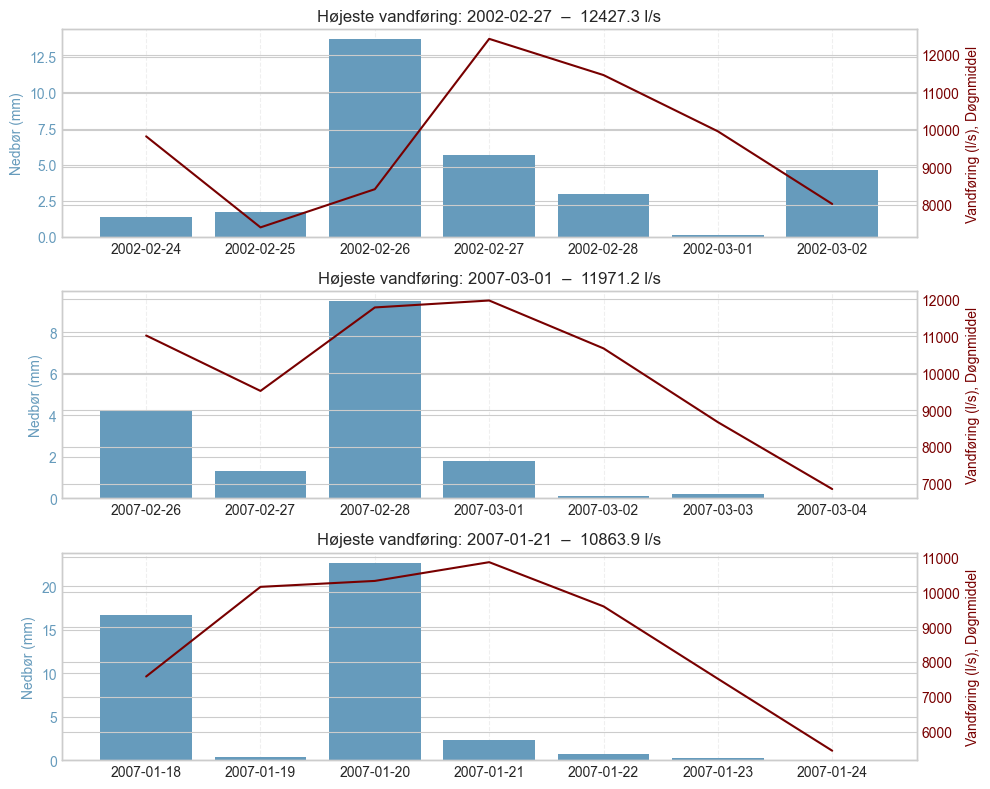

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

# Color palette
colors = {
    "barn_red": "#780000",
    "fire_brick": "#c1121f",
    "beaver": "#9F7E69",
    "dun": "#D2BBA0",
    "prussian_blue": "#003049",
    "air_superiority_blue": "#669bbc",
    "fern_green": "#4F7942",
    "light_fern_green": "#84A17B",
    "muted_purple": "#6A4C93",
    "light_muted_purple": "#9782B3"
}

def plot_top3_flow_peaks(data: pd.DataFrame,
                         target='KarupBro',
                         precip='precip_total_daily',
                         days_before=3,
                         days_after=3):
    """Tegn 3 zoom-plots omkring de højeste døgnmiddel-vandføringer uden overlap."""
    # 1) sorter alle døgnmiddel-værdier i faldende rækkefølge
    sorted_peaks = data[target].nlargest(len(data))
    
    # 2) vælg top 3 uden overlap på ±days_before/after
    selected = []
    windows = []
    for peak_time, peak_val in sorted_peaks.items():
        start = peak_time - pd.Timedelta(days=days_before)
        end   = peak_time + pd.Timedelta(days=days_after)
        # tjek at [start, end] ikke overlapper tidligere vinduer
        if all(end < w_start or start > w_end for w_start, w_end in windows):
            selected.append((peak_time, peak_val))
            windows.append((start, end))
            if len(selected) == 3:
                break

    # 3) plot subplots
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=False)
    for ax, (peak_time, peak_val) in zip(axes, selected):
        win = data.loc[
            peak_time - pd.Timedelta(days=days_before):
            peak_time + pd.Timedelta(days=days_after)
        ]

        # Nedbør som søjler (prussian blue)
        ax.bar(win.index, win[precip],
               color=colors["air_superiority_blue"],
               label='Nedbør (mm)')
        ax.set_ylabel("Nedbør (mm)", color=colors["air_superiority_blue"])
        ax.tick_params(axis='y', labelcolor=colors["air_superiority_blue"])

        # Vandføring som linje (barn red)
        ax2 = ax.twinx()
        ax2.plot(win.index, win[target],
                 color=colors["barn_red"],
                 label='Vandføring (l/s), Døgnmiddel')
        ax2.set_ylabel("Vandføring (l/s), Døgnmiddel", color=colors["barn_red"])
        ax2.tick_params(axis='y', labelcolor=colors["barn_red"])

        ax.set_title(
            f"Højeste vandføring: {peak_time.date()}  –  {peak_val:.1f} l/s"
        )
        ax.grid(True, axis='x', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Kør funktionen på din DataFrame
plot_top3_flow_peaks(df)

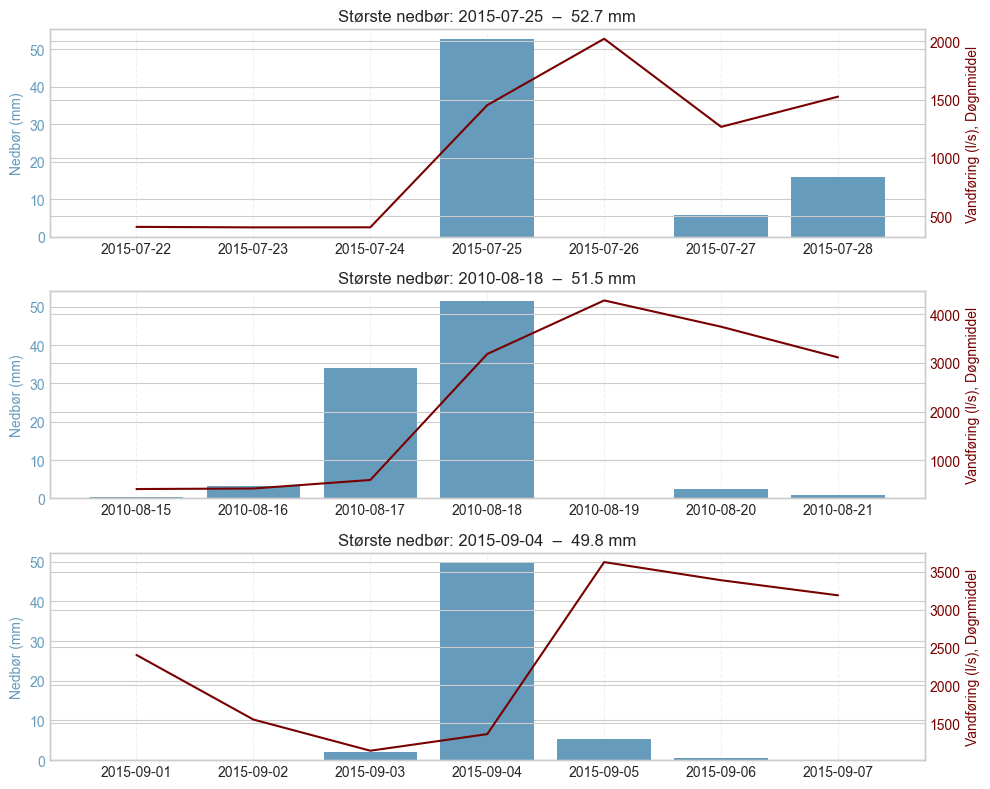

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

# Color palette
colors = {
    "barn_red": "#780000",
    "fire_brick": "#c1121f",
    "beaver": "#9F7E69",
    "dun": "#D2BBA0",
    "prussian_blue": "#003049",
    "air_superiority_blue": "#669bbc",
    "fern_green": "#4F7942",
    "light_fern_green": "#84A17B",
    "muted_purple": "#6A4C93",
    "light_muted_purple": "#9782B3"
}

def plot_top3_precip_peaks(data: pd.DataFrame,
                           target='KarupBro',
                           precip='precip_total_daily',
                           days_before=3,
                           days_after=3):
    """Tegn 3 zoom-plots omkring de største nedbørsdage uden overlap."""
    # 1) sorter alle nedbørsværdier i faldende rækkefølge
    sorted_peaks = data[precip].nlargest(len(data))
    
    # 2) vælg top 3 uden overlap på ±days_before/after
    selected = []
    windows = []
    for peak_time, peak_val in sorted_peaks.items():
        start = peak_time - pd.Timedelta(days=days_before)
        end   = peak_time + pd.Timedelta(days=days_after)
        if all(end < w_start or start > w_end for w_start, w_end in windows):
            selected.append((peak_time, peak_val))
            windows.append((start, end))
            if len(selected) == 3:
                break

    # 3) plot subplots
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=False)
    for ax, (peak_time, precip_val) in zip(axes, selected):
        win = data.loc[
            peak_time - pd.Timedelta(days=days_before):
            peak_time + pd.Timedelta(days=days_after)
        ]

        # Nedbør som søjler (prussian blue)
        ax.bar(win.index, win[precip],
               color=colors["air_superiority_blue"],
               label='Nedbør (mm)')
        ax.set_ylabel("Nedbør (mm)", color=colors["air_superiority_blue"])
        ax.tick_params(axis='y', labelcolor=colors["air_superiority_blue"])

        # Vandføring som linje (barn red)
        ax2 = ax.twinx()
        ax2.plot(win.index, win[target],
                 color=colors["barn_red"],
                 label='Vandføring (l/s), Døgnmiddel')
        ax2.set_ylabel("Vandføring (l/s), Døgnmiddel", color=colors["barn_red"])
        ax2.tick_params(axis='y', labelcolor=colors["barn_red"])

        ax.set_title(
            f"Største nedbør: {peak_time.date()}  –  {precip_val:.1f} mm"
        )
        ax.grid(True, axis='x', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Kør funktionen på din DataFrame
plot_top3_precip_peaks(df)


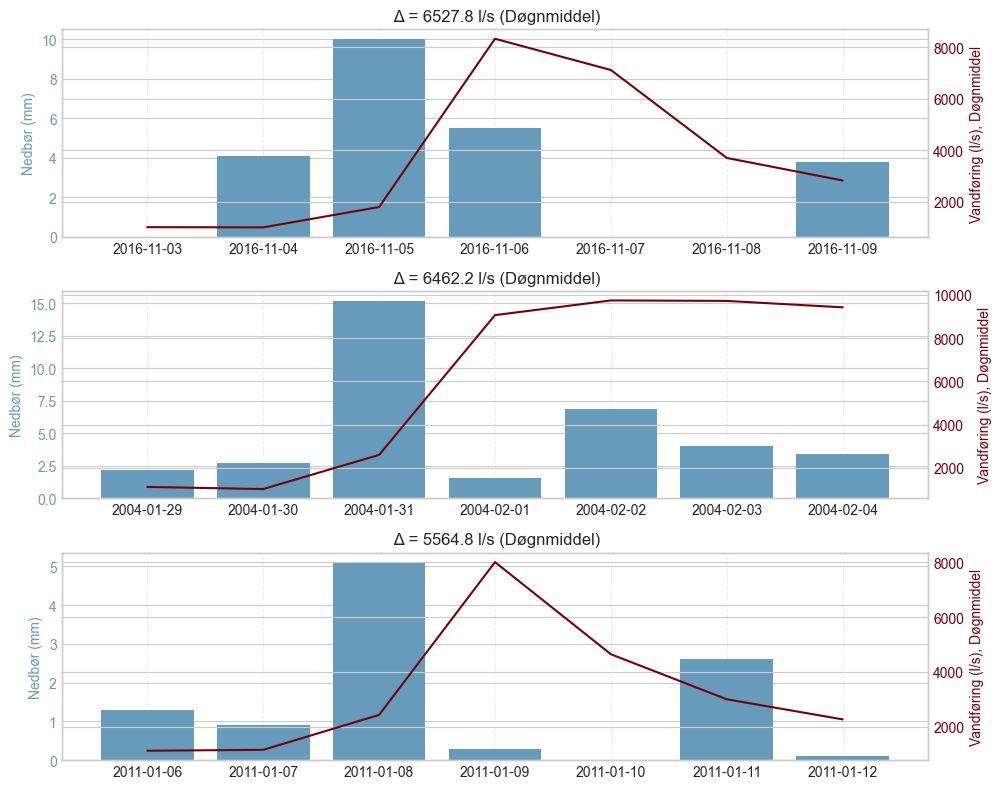

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

# Color palette
colors = {
    "barn_red": "#780000",
    "fire_brick": "#c1121f",
    "beaver": "#9F7E69",
    "dun": "#D2BBA0",
    "prussian_blue": "#003049",
    "air_superiority_blue": "#669bbc",
    "fern_green": "#4F7942",
    "light_fern_green": "#84A17B",
    "muted_purple": "#6A4C93",
    "light_muted_purple": "#9782B3"
}

def plot_top3_inflow_changes(data: pd.DataFrame,
                              target='KarupBro',
                              precip='precip_total_daily',
                              days_before=3,
                              days_after=3):
    """Tegn 3 zoom-plots omkring de største dag-til-dag-stigninger i inflow."""
    # 1) beregn daglige ændringer
    changes = data[target].diff()  # forskel mellem dag i dag og dag før
    # 2) find top 3 datoer med størst positiv ændring
    top_changes = changes.nlargest(3)

    # 3) forbered subplots
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=False)

    for ax, (peak_time, change_val) in zip(axes, top_changes.items()):
        # definer vinduet omkring peak_time
        window = data.loc[
            peak_time - pd.Timedelta(days=days_before):
            peak_time + pd.Timedelta(days=days_after)
        ]

        # Nedbør som søjler (venstre akse) i prussian blue
        ax.bar(window.index, window[precip],
               color=colors["air_superiority_blue"],
               label='Nedbør (mm)')
        ax.set_ylabel("Nedbør (mm)", color=colors["air_superiority_blue"])
        ax.tick_params(axis='y', labelcolor=colors["air_superiority_blue"])

        # Inflow som linje (højre akse) i barn red
        ax2 = ax.twinx()
        ax2.plot(window.index, window[target],
                 color=colors["barn_red"],
                 linestyle='-',
                 label='Vandføring (l/s), Døgnmiddel')
        ax2.set_ylabel("Vandføring (l/s), Døgnmiddel", color=colors["barn_red"])
        ax2.tick_params(axis='y', labelcolor=colors["barn_red"])

        # Titel med dato og ændring
        ax.set_title(
            f" Δ = {change_val:.1f} l/s (Døgnmiddel)"
        )
        ax.grid(True, axis='x', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_top3_inflow_changes(df)


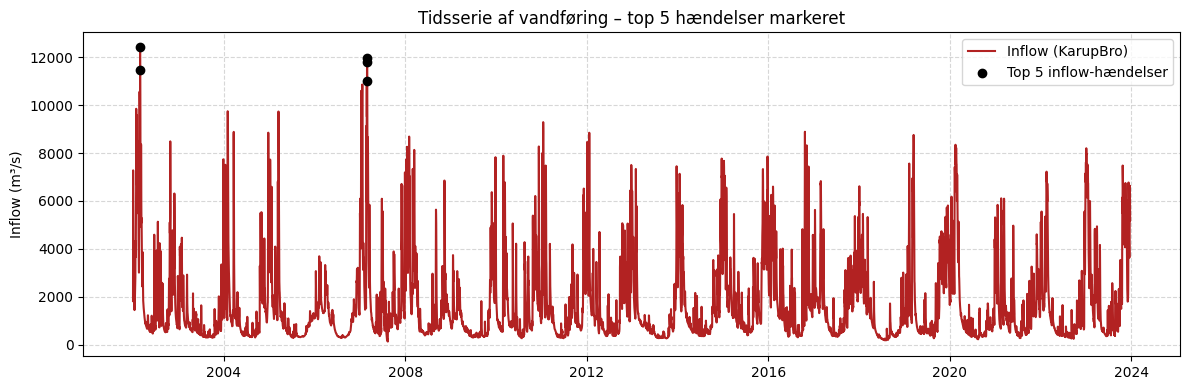

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Sortér og find de 5 højeste inflows
top5 = df['KarupBro'].nlargest(5)

# Plot hele serien med markeringer
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['KarupBro'], label='Inflow (KarupBro)', color='firebrick')
plt.scatter(top5.index, top5.values, color='black', zorder=5, label='Top 5 inflow-hændelser')
plt.title("Tidsserie af vandføring – top 5 hændelser markeret")
plt.ylabel("Inflow (m³/s)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

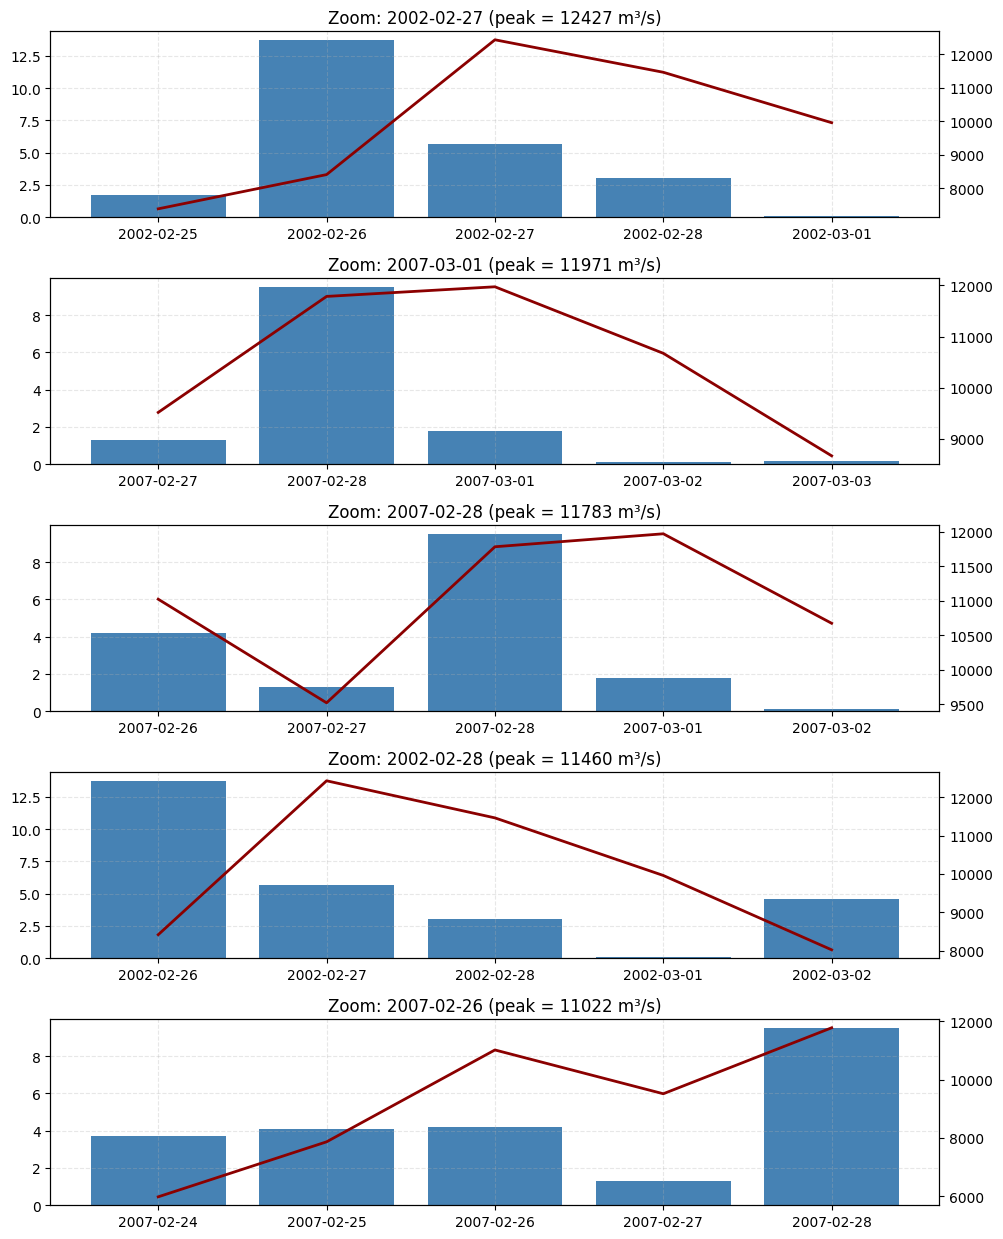

In [8]:
def plot_zoom_on_peaks(df, peaks, window=2):
    fig, axes = plt.subplots(len(peaks), 1, figsize=(10, 2.5*len(peaks)))
    for i, (ts, val) in enumerate(peaks.items()):
        ax = axes[i] if len(peaks) > 1 else axes
        win = df.loc[ts - pd.Timedelta(days=window): ts + pd.Timedelta(days=window)]
        ax.bar(win.index, win['precip_total_daily'], color='steelblue', label='Nedbør')
        ax2 = ax.twinx()
        ax2.plot(win.index, win['KarupBro'], color='darkred', lw=2, label='Inflow')
        ax.set_title(f"Zoom: {ts.date()} (peak = {val:.0f} m³/s)")
        ax.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_zoom_on_peaks(df, top5)

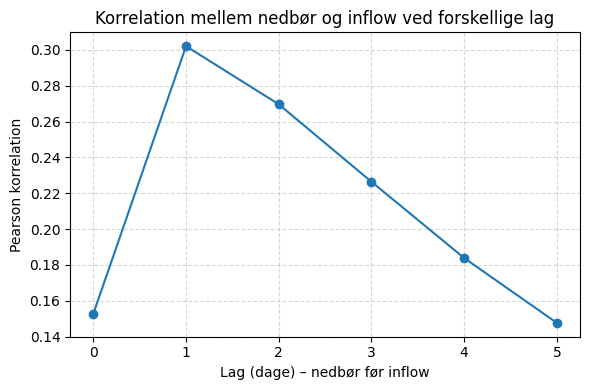

In [9]:
import numpy as np

max_lag = 5
cors = [df['precip_total_daily'].corr(df['KarupBro'].shift(-k)) for k in range(max_lag+1)]

plt.figure(figsize=(6, 4))
plt.plot(range(max_lag+1), cors, marker='o')
plt.xticks(range(max_lag+1))
plt.title("Korrelation mellem nedbør og inflow ved forskellige lag")
plt.xlabel("Lag (dage) – nedbør før inflow")
plt.ylabel("Pearson korrelation")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


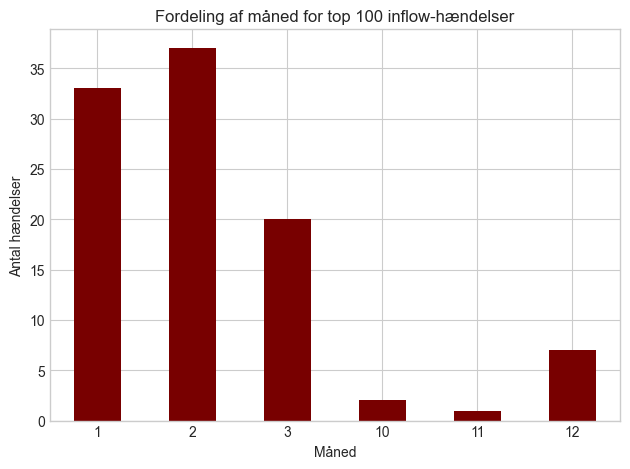

In [45]:
topN = df['KarupBro'].nlargest(100)
topN_months = topN.index.month

topN_months.value_counts().sort_index().plot(kind='bar', color='#780000')
plt.title("Fordeling af måned for top 100 inflow-hændelser")
plt.xlabel("Måned")
plt.ylabel("Antal hændelser")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

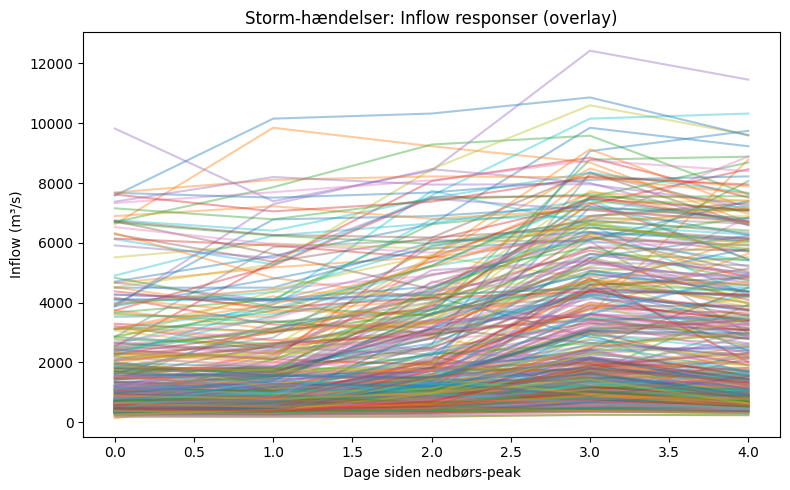

In [11]:
def extract_windows(data, p_thresh, pad=2):
    mask = data['precip_total_daily'] > p_thresh
    storms = []
    for i in range(len(mask)):
        if mask.iloc[i]:
            t = mask.index[i]
            win = data.loc[t - pd.Timedelta(days=pad): t + pd.Timedelta(days=pad)]
            storms.append(win)
    return storms

# Ekstreme nedbørshændelser
q_p = df['precip_total_daily'].quantile(0.95)
storms = extract_windows(df, q_p)

# Plot overlay
plt.figure(figsize=(8, 5))
for s in storms:
    rel_days = (s.index - s.index[0]).days
    plt.plot(rel_days, s['KarupBro'], alpha=0.4)
plt.title("Storm-hændelser: Inflow responser (overlay)")
plt.xlabel("Dage siden nedbørs-peak")
plt.ylabel("Inflow (m³/s)")
plt.tight_layout()
plt.show()

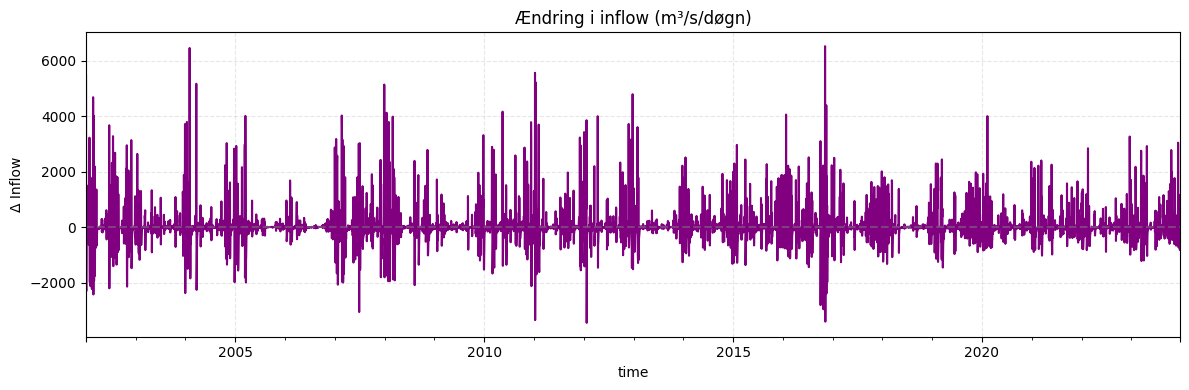

In [12]:
df['inflow_diff'] = df['KarupBro'].diff()

plt.figure(figsize=(12, 4))
df['inflow_diff'].plot(color='purple')
plt.axhline(0, linestyle='--', color='gray', alpha=0.5)
plt.title("Ændring i inflow (m³/s/døgn)")
plt.ylabel("Δ Inflow")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

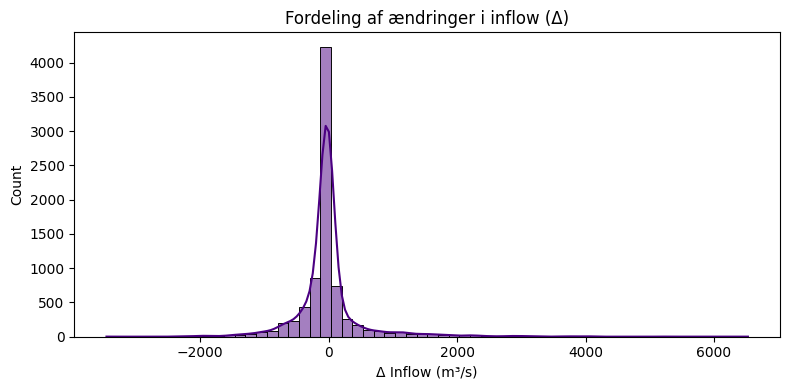

In [13]:
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(df['inflow_diff'].dropna(), bins=60, kde=True, color='indigo')
plt.title("Fordeling af ændringer i inflow (Δ)")
plt.xlabel("Δ Inflow (m³/s)")
plt.tight_layout()
plt.show()

In [17]:
top_rise = df['inflow_diff'].nlargest(5)

print("🔼 Kraftigste stigninger:\n", top_rise)

🔼 Kraftigste stigninger:
 time
2016-11-06    6527.78
2004-02-01    6462.23
2011-01-09    5564.82
2002-01-02    5449.71
2011-01-14    5218.24
Name: inflow_diff, dtype: float64


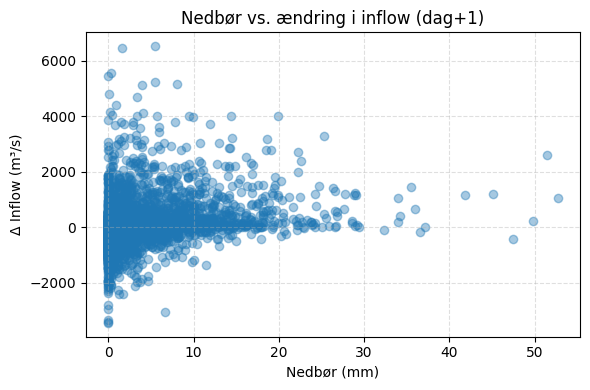

In [15]:
plt.figure(figsize=(6,4))
plt.scatter(df['precip_total_daily'], df['inflow_diff'], alpha=0.4)
plt.xlabel("Nedbør (mm)")
plt.ylabel("Δ Inflow (m³/s)")
plt.title("Nedbør vs. ændring i inflow (dag+1)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

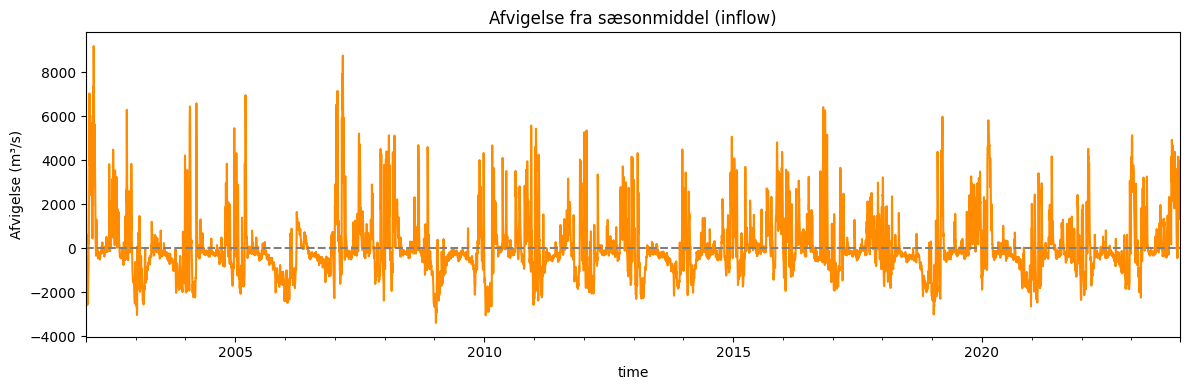

In [16]:
# Forventet inflow pr. dag på året (DOY)
seasonal_mean = df.groupby(df.index.dayofyear)['KarupBro'].mean()
df['dayofyear'] = df.index.dayofyear
df['inflow_vs_season'] = df['KarupBro'] - df['dayofyear'].map(seasonal_mean)

# Plot
plt.figure(figsize=(12,4))
df['inflow_vs_season'].plot(color='darkorange')
plt.axhline(0, ls='--', color='gray')
plt.title("Afvigelse fra sæsonmiddel (inflow)")
plt.ylabel("Afvigelse (m³/s)")
plt.tight_layout()
plt.show()